In [ ]:
#from mckay johns videos

import json
# from selenium.webdriver.chrome.service import Service as ChromeService
# from webdriver_manager.chrome import ChromeDriverManager # version 4.0.1

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

options = Options()
options.set_capability("goog:loggingPrefs", {"performance": "ALL", "browser": "ALL"})

# Headless often helps on CI / servers — optional:
# options.add_argument("--headless=new")

# Let Selenium Manager fetch the right driver
driver = webdriver.Chrome(options=options)
driver.set_page_load_timeout(10)

try:
    driver.get("https://www.sofascore.com/football/match/manchester-city-wolverhampton/dsr#id:12436562,tab:statistics")
except Exception as e:
    print("Navigation issue:", e)

driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")



# extract requests from logs
logs_raw = driver.get_log("performance")
logs = [json.loads(lr["message"])["message"] for lr in logs_raw]

for x in logs:
    if 'shotmap' in x['params'].get('headers', {}).get(':path', ''):
        print(x['params'].get('headers', {}).get(':path'))
        break

test = json.loads(driver.execute_cdp_cmd('Network.getResponseBody', {'requestId': x["params"]["requestId"]})['body'])['shotmap']
test[0]


Navigation issue: Message: timeout: Timed out receiving message from renderer: 9.476
  (Session info: chrome=139.0.7258.67)
Stacktrace:
0   chromedriver                        0x000000010fe28ef8 chromedriver + 5918456
1   chromedriver                        0x000000010fe2048a chromedriver + 5883018
2   chromedriver                        0x000000010f8ece20 chromedriver + 429600
3   chromedriver                        0x000000010f8d4e12 chromedriver + 331282
4   chromedriver                        0x000000010f8d4b4b chromedriver + 330571
5   chromedriver                        0x000000010f8d2a04 chromedriver + 322052
6   chromedriver                        0x000000010f8d333f chromedriver + 324415
7   chromedriver                        0x000000010f8e1db3 chromedriver + 384435
8   chromedriver                        0x000000010f8fb60d chromedriver + 488973
9   chromedriver                        0x000000010f901d2b chromedriver + 515371
10  chromedriver                        0x000000010f

{'player': {'name': 'Mateo Kovačić',
  'slug': 'mateo-kovacic',
  'shortName': 'M. Kovačić',
  'position': 'M',
  'jerseyNumber': '8',
  'userCount': 38642,
  'sofascoreId': 'Kova8',
  'id': 136710,
  'fieldTranslations': {'nameTranslation': {'ar': 'ماتيو كوفاسيتش',
    'hi': 'माटेओ कोवासिक',
    'bn': 'মাতেও কোভাসিক'},
   'shortNameTranslation': {'ar': 'م. كوفاسيتش',
    'hi': 'एम. कोवासिक',
    'bn': 'এম. কোভাসিচ'}}},
 'isHome': True,
 'shotType': 'miss',
 'situation': 'assisted',
 'playerCoordinates': {'x': 21.7, 'y': 60.8, 'z': 0},
 'bodyPart': 'right-foot',
 'goalMouthLocation': 'left',
 'goalMouthCoordinates': {'x': 0, 'y': 60.3, 'z': 8.3},
 'xg': 0.023230485618114,
 'xgot': 0,
 'id': 4867359,
 'time': 70,
 'timeSeconds': 4179,
 'draw': {'start': {'x': 60.8, 'y': 21.7},
  'end': {'x': 39.7, 'y': 0},
  'goal': {'x': 39.7, 'y': 91.7}},
 'reversedPeriodTime': 21,
 'reversedPeriodTimeSeconds': 1221,
 'periodTimeSeconds': 1479,
 'incidentType': 'shot'}

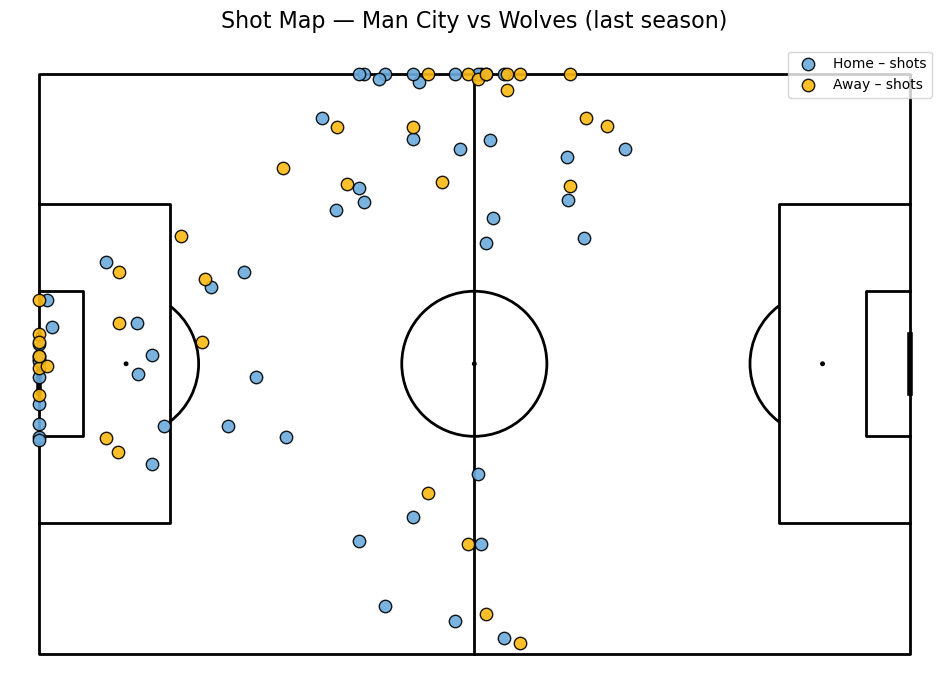

,team,minute,xg,goal,situation,x_raw,y_raw
10,Away,None,None,False,None,16.3,28.0
11,Away,None,None,False,None,0.0,55.3
12,Away,None,None,False,None,28.0,16.3
13,Away,None,None,False,None,44.7,0.0
14,Away,None,None,False,None,44.7,72.2
41,Away,None,None,False,None,9.1,65.2
42,Away,None,None,False,None,0.0,50.7
43,Away,None,None,False,None,7.7,62.8
44,Away,None,None,False,None,65.2,9.1
45,Away,None,None,False,None,62.8,7.7


In [ ]:

import json
import time
import base64
from typing import Any, Dict, List, Tuple, Optional

import pandas as pd
import matplotlib.pyplot as plt

from selenium.webdriver.chrome.options import Options

EVENT_ID = 12436562
MATCH_URL = f"https://www.sofascore.com/football/match/manchester-city-wolverhampton/dsr#id:{EVENT_ID},tab:statistics"
API_URL  = f"https://api.sofascore.com/api/v1/event/{EVENT_ID}/shotmap"

def get_shotmap_body() -> str:
    """Try CDP first, else hit the public API."""
    body = None
    base64_encoded = False

    options = Options()
    options.set_capability("goog:loggingPrefs", {"performance": "ALL", "browser": "ALL"})

    driver = webdriver.Chrome(options=options)
    driver.set_page_load_timeout(30)

    try:
        try:
            driver.execute_cdp_cmd("Network.enable", {})
        except Exception:
            pass

        driver.get(MATCH_URL)
        for _ in range(3):
            time.sleep(1.2)
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        def perf_events():
            out = []
            for lr in driver.get_log("performance"):
                try:
                    out.append(json.loads(lr["message"])["message"])
                except Exception:
                    pass
            return out

        events = perf_events()
        deadline = time.time() + 6
        shotmap_request_id = None

        def find_shotmap_request_id(evts):
            for ev in evts:
                if ev.get("method") == "Network.requestWillBeSent":
                    p = ev.get("params", {})
                    req = p.get("request", {})
                    url = (req.get("url") or "").lower()
                    path = (p.get("headers", {}).get(":path") or "").lower()
                    if "shotmap" in url or "shotmap" in path:
                        return p.get("requestId")
            return None

        shotmap_request_id = find_shotmap_request_id(events)
        while not shotmap_request_id and time.time() < deadline:
            time.sleep(0.8)
            events.extend(perf_events())
            shotmap_request_id = find_shotmap_request_id(events)

        def try_get_body(rid):
            if not rid:
                return None, False
            try:
                resp = driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": rid})
                return resp.get("body", ""), resp.get("base64Encoded", False)
            except Exception:
                return None, False

        if shotmap_request_id:
            body, base64_encoded = try_get_body(shotmap_request_id)

        if not body:
            for ev in reversed(events):
                if ev.get("method") == "Network.responseReceived":
                    url = (ev.get("params", {}).get("response", {}).get("url") or "").lower()
                    if "shotmap" in url:
                        rid = ev.get("params", {}).get("requestId")
                        body, base64_encoded = try_get_body(rid)
                        if body:
                            break
    finally:
        driver.quit()

    if not body:
        import requests
        r = requests.get(API_URL, headers={"User-Agent": "Mozilla/5.0"}, timeout=20)
        r.raise_for_status()
        body = r.text
        base64_encoded = False

    if base64_encoded and body:
        try:
            body = base64.b64decode(body).decode("utf-8", errors="ignore")
        except Exception:
            pass

    return body

body = get_shotmap_body()
parsed = json.loads(body)

CANDIDATE_PAIRS = [
    ("x", "y"),
    ("shotX", "shotY"),
    ("coordinateX", "coordinateY"),
    ("posX", "posY"),
    ("startX", "startY"),
]

TEAM_KEYS = ["teamName", "team", "teamId", "side", "homeAway", "isHome"]

def is_number(v):
    try:
        float(v)
        return True
    except Exception:
        return False

def extract_team_meta(d: Dict[str, Any]) -> Dict[str, Any]:
    meta = {}
    for k in TEAM_KEYS:
        if k in d:
            meta[k] = d[k]
    if isinstance(d.get("team"), dict):
        meta["teamId"] = d["team"].get("id", meta.get("teamId"))
        meta["teamName"] = d["team"].get("name", meta.get("teamName"))
    if "isHome" in d:
        meta["homeAway"] = "home" if d["isHome"] else "away"
    return meta

def walk(obj: Any, context_stack: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    found = []
    if isinstance(obj, dict):
        meta_here = extract_team_meta(obj)
        if meta_here:
            context_stack = context_stack + [meta_here]

        for xa, ya in CANDIDATE_PAIRS:
            if xa in obj and ya in obj and is_number(obj[xa]) and is_number(obj[ya]):
                shot = {
                    "x_raw": float(obj[xa]),
                    "y_raw": float(obj[ya]),
                    "goal": bool(obj.get("isGoal", obj.get("goal", False))),
                    "xg": obj.get("xg", obj.get("expectedGoals")),
                    "situation": obj.get("situation") or obj.get("shotType") or obj.get("shotTypeName"),
                    "minute": obj.get("time", obj.get("minute")),
                }
                team_id = obj.get("teamId")
                team_name = obj.get("teamName")
                home_away = obj.get("homeAway")
                for ctx in reversed(context_stack):
                    team_id = team_id or ctx.get("teamId")
                    team_name = team_name or ctx.get("teamName")
                    home_away = home_away or ctx.get("homeAway") or ("home" if ctx.get("isHome") else None)
                shot["team_id"] = team_id
                shot["team"] = team_name
                shot["homeAway"] = home_away
                found.append(shot)
                break

        for v in obj.values():
            found.extend(walk(v, context_stack))
    elif isinstance(obj, list):
        for v in obj:
            found.extend(walk(v, context_stack))
    return found

shots = walk(parsed, [])

if isinstance(parsed, dict) and "shotmap" in parsed and isinstance(parsed["shotmap"], list):
    from_shotmap = walk(parsed["shotmap"], [])
    if len(from_shotmap) > 0:
        shots = from_shotmap

if not shots:
    print("Top-level keys:", list(parsed.keys()) if isinstance(parsed, dict) else type(parsed))
    raise ValueError("No shots found: JSON didn’t expose any recognized coordinate keys.")

df = pd.DataFrame(shots)

def detect_scale(series: pd.Series) -> float:
    s = series.dropna()
    if s.empty:
        return 100.0
    if s.max() <= 1.5:  
        return 1.0
    if s.max() <= 100.5:
        return 100.0
    return s.max()   

scale_x = detect_scale(df["x_raw"])
scale_y = detect_scale(df["y_raw"])

df["x"] = df["x_raw"] * (120.0 / (1.0 if scale_x <= 1.5 else 100.0 if scale_x <= 100.5 else scale_x))
df["y"] = df["y_raw"] * (80.0  / (1.0 if scale_y <= 1.5 else 100.0 if scale_y <= 100.5 else scale_y))

if df["team"].isna().any() and df["team_id"].notna().any():
    name_map = (
        df.dropna(subset=["team_id"])
          .groupby("team_id")["team"]
          .agg(lambda s: s.dropna().mode().iloc[0] if not s.dropna().empty else None)
          .to_dict()
    )
    df["team"] = df.apply(lambda r: name_map.get(r["team_id"], r["team"]), axis=1)

if df["team"].isna().any():
    df.loc[df["team"].isna() & df["homeAway"].notna(), "team"] = df["homeAway"].str.capitalize()

if df["team"].isna().any():
    ids = df["team_id"].fillna("NA").astype(str)
    id_order = ids.value_counts().index.tolist()
    id_to_generic = {i: f"Team {k+1}" for k, i in enumerate(id_order[:2])}
    df.loc[df["team"].isna(), "team"] = ids.map(lambda v: id_to_generic.get(v, "Team"))

try:
    from mplsoccer import Pitch
    use_mplsoccer = True
except Exception:
    use_mplsoccer = False

if use_mplsoccer:
    pitch = Pitch(pitch_type="statsbomb", line_color="black", pitch_color="white")
    fig, ax = pitch.draw(figsize=(10, 7))
else:
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_xlim(0, 120); ax.set_ylim(0, 80)
    ax.set_aspect('equal'); ax.axis('off')
    ax.plot([0,120,120,0,0],[0,0,80,80,0], color="black", lw=1)
    ax.plot([60,60],[0,80], color="black", lw=1)

teams = list(df["team"].unique())
palette = ["#6CABDD", "#FDB913"]

for i, t in enumerate(teams[:2]):
    sub = df[df["team"] == t]
    non_goals = sub[~sub["goal"]]
    goals = sub[sub["goal"]]

    if use_mplsoccer:
        if not non_goals.empty:
            pitch.scatter(non_goals["x"], non_goals["y"], ax=ax, s=80, c=palette[i%2], edgecolors="black", alpha=0.9, label=f"{t} – shots")
        if not goals.empty:
            pitch.scatter(goals["x"], goals["y"], ax=ax, s=160, c=palette[i%2], marker="*", edgecolors="black", linewidth=0.8, label=f"{t} – goals")
    else:
        ax.scatter(non_goals["x"], non_goals["y"], s=80, c=palette[i%2], edgecolors="black", alpha=0.9, label=f"{t} – shots")
        ax.scatter(goals["x"], goals["y"], s=160, c=palette[i%2], marker="*", edgecolors="black", linewidths=0.8, label=f"{t} – goals")

ax.set_title("Shot Map — Man City vs Wolves (last season)", fontsize=16, pad=12)
ax.legend(loc="upper right")
plt.show()

display(df[["team","minute","xg","goal","situation","x_raw","y_raw"]].sort_values(["team","minute"]).head(12))


After filtering: 0 shots total


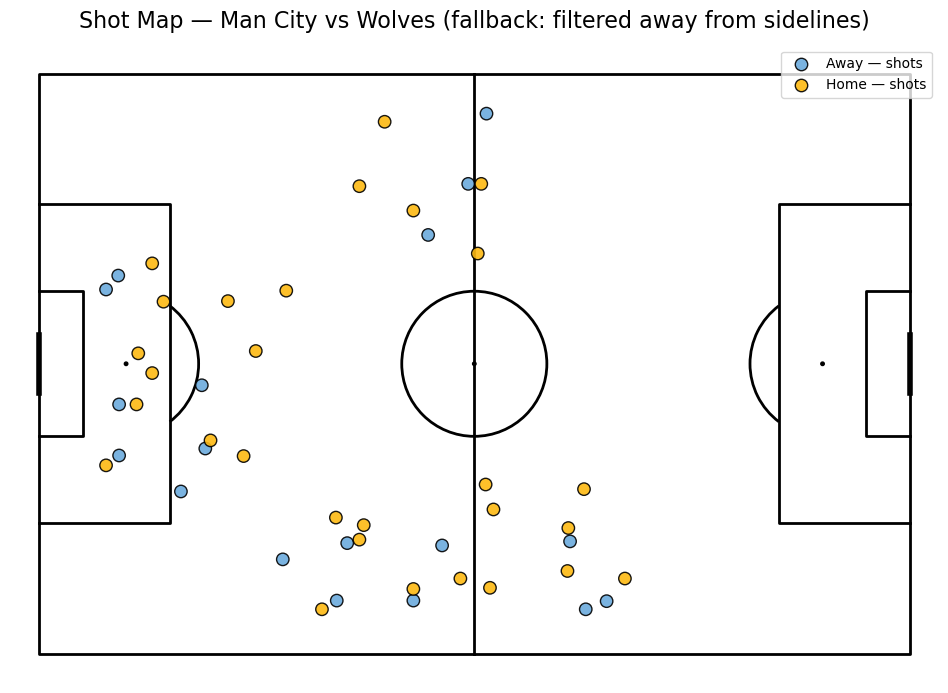

Plotted rows: 47  |  with xG: 0


,team,minute,xg,xg_num,goal,x,y
0,Home,None,None,NaN,False,26.04,31.36
2,Home,None,None,NaN,False,72.96,62.64
4,Home,None,None,NaN,False,47.64,6.64
5,Home,None,None,NaN,False,17.16,31.44
7,Home,None,None,NaN,False,72.84,68.56
9,Home,None,None,NaN,False,44.76,62.24
10,Away,None,None,NaN,False,19.56,57.60
12,Away,None,None,NaN,False,33.60,66.96
14,Away,None,None,NaN,False,53.64,22.24
15,Home,None,None,NaN,False,28.20,52.72


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

possible_xg_cols = ["xg", "expectedGoals", "xG", "xgValue", "shotXg", "shotxg"]
present = [c for c in possible_xg_cols if c in df.columns]

xg_num = None
for c in present:
    s = pd.to_numeric(df[c], errors="coerce")
    if s.notna().sum() > 0:
        xg_num = s
        break

if xg_num is None and "xg" in df.columns:
    xg_num = pd.to_numeric(df["xg"].astype(str).str.extract(r"([0-9]*\.?[0-9]+)")[0], errors="coerce")

df["xg_num"] = xg_num
MIN_BORDER = 5.0
mask_inside = df["x"].between(MIN_BORDER, 120 - MIN_BORDER) & df["y"].between(MIN_BORDER, 80 - MIN_BORDER)

if df["xg_num"].notna().sum() > 0:
    df_plot = df[df["xg_num"].notna()].copy()
    title_suffix = "(xG-assigned shots only)"
else:
    df_plot = df[mask_inside].copy()
    title_suffix = "(fallback: filtered away from sidelines)"

teams = list(df_plot["team"].dropna().unique())
teams_sorted = sorted(teams, key=lambda t: (t or ""))

palette = {"Manchester City": "#6CABDD", "Wolverhampton Wanderers": "#FDB913"}
fallback_cols = ["#6CABDD", "#FDB913"]

try:
    from mplsoccer import Pitch
    USE_MPLSOCCER = True
except Exception:
    USE_MPLSOCCER = False

if USE_MPLSOCCER:
    pitch = Pitch(pitch_type="statsbomb", line_color="black", pitch_color="white")
    fig, ax = pitch.draw(figsize=(10, 7))
else:
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_xlim(0, 120); ax.set_ylim(0, 80)
    ax.set_aspect('equal'); ax.axis('off')
    ax.plot([0,120,120,0,0],[0,0,80,80,0], color="black", lw=1)
    ax.plot([60,60],[0,80], color="black", lw=1)

def size_from_xg(s):
    base = 400
    return np.clip((s.fillna(0) ** 0.5) * base, 60, 300)

title = f"Shot Map — Man City vs Wolves {title_suffix}"

for i, team in enumerate(teams_sorted[:2]):
    sub = df_plot[df_plot["team"] == team]
    if sub.empty:
        continue
    col = palette.get(team, fallback_cols[i % len(fallback_cols)])
    non_goals = sub[~sub["goal"]]
    goals = sub[sub["goal"]]

    if df["xg_num"].notna().sum() > 0:
        sizes = size_from_xg(non_goals["xg_num"])
        sizes_g = size_from_xg(goals["xg_num"])
    else:
        sizes = np.full(len(non_goals), 80.0)
        sizes_g = np.full(len(goals), 160.0)

    if USE_MPLSOCCER:
        if not non_goals.empty:
            pitch.scatter(non_goals["x"], non_goals["y"], ax=ax, s=sizes,
                          c=col, edgecolors="black", alpha=0.9, label=f"{team} — shots")
        if not goals.empty:
            pitch.scatter(goals["x"], goals["y"], ax=ax, s=sizes_g,
                          c=col, marker="*", edgecolors="black", linewidth=0.8, label=f"{team} — goals")
    else:
        ax.scatter(non_goals["x"], non_goals["y"], s=sizes,
                   c=col, edgecolors="black", alpha=0.9, label=f"{team} — shots")
        ax.scatter(goals["x"], goals["y"], s=sizes_g,
                   c=col, marker="*", edgecolors="black", linewidths=0.8, label=f"{team} — goals")

ax.set_title(title, fontsize=16, pad=12)
ax.legend(loc="upper right")
plt.show()

print(f"Plotted rows: {len(df_plot)}  |  with xG: {df['xg_num'].notna().sum()}")
display(df_plot[["team","minute","xg","xg_num","goal","x","y"]].head(12))
